In [1]:
from kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
SAMPLES = 256
SEED = 2023

# Experiment 3

Posterior Fit Performance compared with CPTP model

In [3]:
cptp_target = std.target_model('CPTP')

/home/jpmarceaux/Applications/pyGSTi/pygsti/modelmembers/operations/lindbladerrorgen.py:1691: UserWarning: Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'
  _warnings.warn("Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'")


In [4]:
# setup the datagen model
max_fogi_error_rate = 0.05
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
fogi_target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [5]:
avg_gs_infidelity(mdl_datagen, fogi_target_model)

0.031208392571299193

In [7]:
# make an edesign and simulate the data
maxLengths = [1,2,4]
edesign = pygsti.protocols.StandardGSTDesign(cptp_target, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [8]:
cptp_mle_estimates, edesigns = make_mle_estimates(dataset, std, cptp_target, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 13.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 28.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 34.1s


In [9]:
prior_cptp_covar = 0.1*np.eye(cptp_target.num_params)

In [10]:
prior_covar_strength =  mserror(mdl_datagen, fogi_target_model)/cptp_target.num_params
prior_covar = prior_covar_strength*np.eye(cptp_target.num_params)

ekf_cptp = ExtendedKalmanFilter(cptp_target, prior_covar)
ekf_cptp.filter_dataset(edesign.circuit_lists[-1], dataset)

ekf_mle_cptp = ExtendedKalmanFilter(cptp_mle_estimates[0], prior_covar)
ekf_mle_cptp.filter_dataset(edesign.circuit_lists[-1], dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:23<00:00, 11.91it/s]


In [12]:
max_loglikelihood(edesign.circuit_lists[-1], dataset)

-827.0989139211781

In [13]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, ekf_cptp.model)

-2259.379452657987

In [14]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, ekf_mle_cptp.model)

-978.9999655083702

In [15]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, cptp_mle_estimates[0])

-1035.6763119679738

In [16]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, cptp_mle_estimates[-1])

-948.726917960521

In [17]:
fogi_mle_estimates, edesigns = make_mle_estimates(dataset, std, fogi_target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.4s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s


In [18]:
prior_covar_strength =  mserror(mdl_datagen, fogi_target_model)/fogi_target_model.num_params
prior_covar = prior_covar_strength*np.eye(fogi_target_model.num_params)

ekf_target_fogi = ExtendedKalmanFilter(fogi_target_model, prior_covar)
ekf_target_fogi.filter_dataset(edesign.circuit_lists[-1], dataset)

ekf_mle_fogi = ExtendedKalmanFilter(fogi_mle_estimates[0], prior_covar)
ekf_mle_fogi.filter_dataset(edesign.circuit_lists[-1], dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:11<00:00, 23.77it/s]


In [19]:
max_loglikelihood(edesign.circuit_lists[-1], dataset)

-827.0989139211781

In [20]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, fogi_mle_estimates[0])

-1029.2681069456496

In [21]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, fogi_mle_estimates[-1])

-956.3151052393509

In [22]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, ekf_target_fogi.model)

-957.0047422897312

In [23]:
experimental_loglikelihood(edesign.circuit_lists[-1], dataset, ekf_mle_fogi.model)

-956.9048344551802

In [24]:
def plot_covar_evals(covar_list):
    evals = []
    for c in covar_list:
        circ_eval, _ = np.linalg.eig(c)
        evals.append(circ_eval)
    plt.matshow(abs(np.array(evals).T))
    
def plot_covar_svals(covar_list):
    svals = []
    for c in covar_list:
        _, circ_sval, _ = np.linalg.svd(c)
        svals.append(circ_sval)
    plt.matshow(abs(np.array(svals).T))

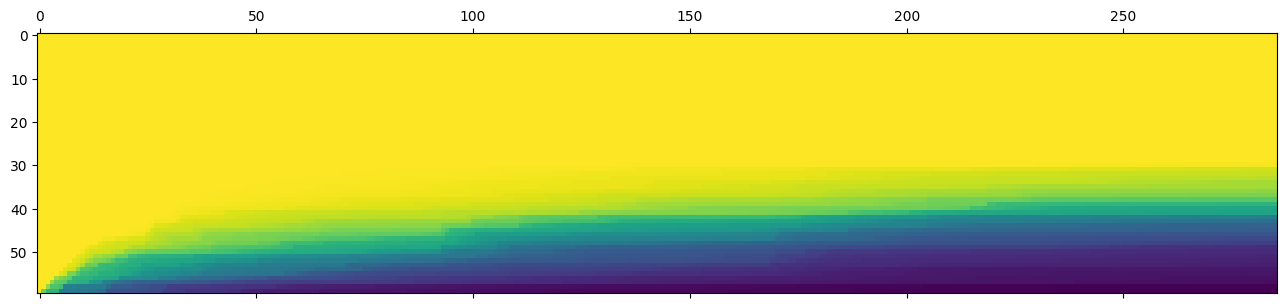

In [25]:
plot_covar_svals(ekf_mle_cptp.covar_history)

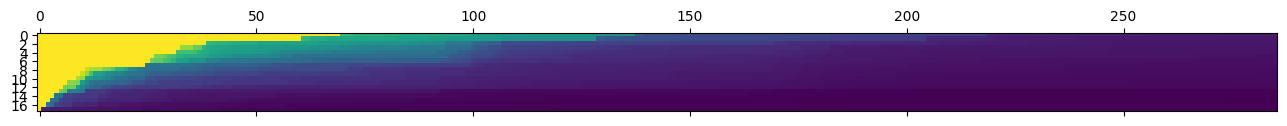

In [26]:
plot_covar_svals(ekf_mle_fogi.covar_history)